### Load libraries

In [2]:
import numpy as np
import pandas as pd
import wandb
import wandb.sdk

import matplotlib.pyplot as plt

In [3]:
def flatten_dict(d: dict, prefix: str = "") -> dict:
    ret = dict()
    for k, v in d.items():
        if isinstance(v, dict):
            ret |= flatten_dict(v, prefix=f"{k}_")
        else:
            ret[f"{prefix}{k}"] = v
    return ret

### Load MSE-trained RNN-decoder data

In [38]:
api = wandb.Api()
runs: list[wandb.sdk.wandb_run.Run] = api.runs(
    f"data-frugal-learning/rnn-decoder",
    filters={"$and": [
        {"tags": {"$in": ["snr_fix"]}},
        {"$not": {"tags": {"$in": ["x_entropy"]}}}
        ]
    }
)

df_all = pd.DataFrame(
    [
        flatten_dict(r.summary._json_dict)  # type: ignore
        | flatten_dict(r.config)
        | {"name": r.name, "state": r.state}
        for r in runs
    ]
)
df_all.columns

df = df_all[df_all.state == "finished"]
mse_df = df.sort_values("num_block")

### Load XE-trained RNN-Decoder data

In [4]:
api = wandb.Api()
runs: list[wandb.sdk.wandb_run.Run] = api.runs(
    f"data-frugal-learning/rnn-decoder",
    filters={"$and": [
        {"tags": {"$in": ["snr_fix"]}},
        {"$not": {"tags": {"$in": ["mse"]}}}
        ]
    }
)


df_all = pd.DataFrame(
    [
        flatten_dict(r.summary._json_dict)  # type: ignore
        | flatten_dict(r.config)
        | {"name": r.name, "state": r.state}
        for r in runs
    ]
)
df_all.columns

df = df_all[df_all.state == "finished"]
xe_df = df.sort_values("num_block")

In [5]:
print(len(xe_df))
xe_df_4 = xe_df[xe_df['train_channel_low'] == 4]
xe_df_0 = xe_df[xe_df['train_channel_low'] == 0]
print(len(xe_df_4))
print(len(xe_df_0))

30
10
10


### Load Viterbi data

In [7]:
runs: list[wandb.sdk.wandb_run.Run] = api.runs(
    f"data-frugal-learning/rnn-decoder",
    filters={"tags": {"$in": ["xe"]}}
)

vdf_all = pd.DataFrame(
    [
        flatten_dict(r.summary._json_dict)  # type: ignore
        | flatten_dict(r.config)
        | {"name": r.name, "state": r.state}
        for r in runs
    ]
)

vdf = vdf_all[vdf_all.state == "finished"]
print(len(vdf))
vdf.columns


1


Index(['mse_5.0', 'mse_6.0', 'bler_1.0', 'bler_-1.0', 'ber_8.0', 'mse_4.0',
       'bler_8.0', 'mse_2.0', 'ber_-1.0', 'mse_1.0', 'mse_7.0', 'xe_0.0',
       'xe_3.0', 'bler_0.0', 'bler_4.0', 'xe_8.0', 'ber_7.0', 'xe_7.0',
       'ber_4.0', 'ber_5.0', 'xe_5.0', 'xe_6.0', 'ber_3.0', 'mse_8.0',
       'xe_-1.0', 'bler_7.0', 'xe_2.0', 'ber_2.0', 'ber_6.0', 'bler_3.0',
       'bler_5.0', 'bler_6.0', 'mse_-1.0', 'xe_1.0', 'xe_4.0', 'mse_0.0',
       'mse_3.0', 'bler_2.0', 'ber_0.0', 'ber_1.0', 'v', 'id', 'enc1', 'enc2',
       'enc3', 'tags', 'num_cpu', 'feedback', 'block_len', 'code_rate',
       'num_block', 'noise_type', 'radar_prob', 'snr_points', 'radar_power',
       'snr_test_end', 'snr_test_start', 'radar_denoise_thd', 'name', 'state'],
      dtype='object')

### Plot MSE-trained RNN-decoder vs Viterbi

Text(0.5, 1.0, 'RNN Decoder vs. Viterbi @ SNR=0')

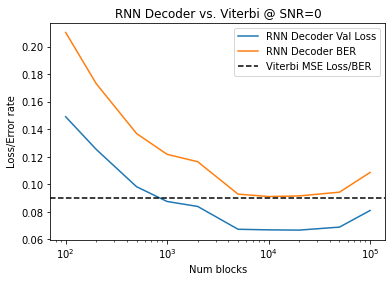

In [39]:

plt.plot(mse_df.num_block, mse_df.val_loss, label="RNN Decoder Val Loss")
plt.plot(mse_df.num_block,mse_df.get('ber_0.0'), label="RNN Decoder BER")
plt.xscale("log")
plt.axhline(float(vdf.get('mse_0.0')),linestyle="--",color="black", label="Viterbi MSE Loss/BER")
plt.xlabel("Num blocks")
plt.ylabel("Loss/Error rate")
plt.legend()
plt.title("RNN Decoder vs. Viterbi @ SNR=0")


Text(0.5, 1.0, 'RNN Decoder vs. Viterbi @ SNR=0')

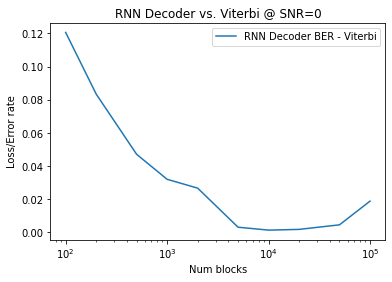

In [45]:
plt.plot(mse_df.num_block,mse_df.get('ber_0.0')-float(vdf.get('mse_0.0')), label="RNN Decoder BER - Viterbi")
plt.xscale("log")
plt.xlabel("Num blocks")
plt.ylabel("Loss/Error rate")
plt.legend()
plt.title("RNN Decoder vs. Viterbi @ SNR=0")

### Plot XE-trained RNN vs Viterbi

Text(0.5, 1.0, 'RNN Decoder vs. Viterbi @ SNR=0')

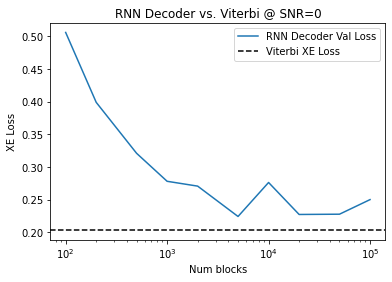

In [17]:
xe_df_0 = xe_df[xe_df['train_channel_low'] == 0]
plt.plot(xe_df_0.num_block, xe_df_0.val_loss, label="RNN Decoder Val Loss")
plt.xscale("log")
plt.axhline(float(vdf.get('xe_0.0')),linestyle="--",color="black", label="Viterbi XE Loss")
plt.xlabel("Num blocks")
plt.ylabel("XE Loss")
plt.legend()
plt.title("RNN Decoder vs. Viterbi @ SNR=0")

Text(0.5, 1.0, 'RNN Decoder vs. Viterbi @ SNR=4')

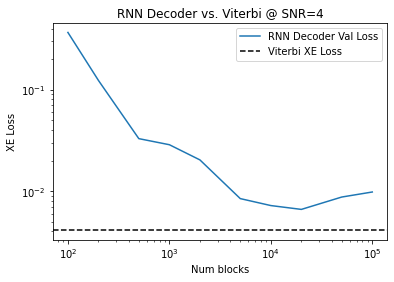

In [18]:
xe_df_4 = xe_df[xe_df['train_channel_low'] == 4]
plt.plot(xe_df_4.num_block, xe_df_4.val_loss, label="RNN Decoder Val Loss")
plt.xscale("log")
plt.yscale("log")
plt.axhline(float(vdf.get('xe_4.0')),linestyle="--",color="black", label="Viterbi XE Loss")
plt.xlabel("Num blocks")
plt.ylabel("XE Loss")
plt.legend()
plt.title("RNN Decoder vs. Viterbi @ SNR=4")

Text(0.5, 1.0, 'RNN Decoder vs. Viterbi @ SNR=8')

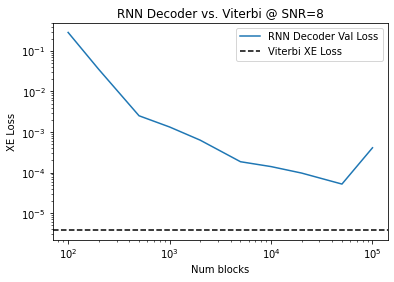

In [8]:
xe_df_8 = xe_df[xe_df['train_channel_low'] == 8]
plt.plot(xe_df_8.num_block, xe_df_8.val_loss, label="RNN Decoder Val Loss")
plt.xscale("log")
plt.yscale("log")
plt.axhline(float(vdf.get('xe_8.0')),linestyle="--",color="black", label="Viterbi XE Loss")
plt.xlabel("Num blocks")
plt.ylabel("XE Loss")
plt.legend()
plt.title("RNN Decoder vs. Viterbi @ SNR=8")